In this notebook, I have used the Pima Diabetes dataset.
This is a classification problem, where we need to predict the target class i.e. diabetic or non-diabetic.  
I first the check acccuracy of various Machine Learning Classification algorithms using lazypredict and then finalize on the algorithm.
Further, I have defined a neural network using Pytorch to improve the accuracy score. The model with better accuracy is saved for which a FAST API endpoint is created. This app is called for inference for some random datapoints from the test set.

#####Install required packages and import modules

In [2]:
!pip install -q torch torchsummary opendatasets lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.

In [3]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyClassifier
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

%matplotlib inline

#####Load the data set and perform **EDA**

In [11]:
df_diab=pd.read_csv('pima-indians-diabetes.csv')

In [12]:
df_diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Preg    768 non-null    int64  
 1   Plas    768 non-null    int64  
 2   Pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


######There are only 768 rows in the dataset which is quite low. However, none of the columns have null values which is good.

In [13]:
df_diab['class'].value_counts()

,count
class,
0,500
1,268


######There is class imbalance which could impact model performance.

In [14]:
df_diab.describe()

,Preg,Plas,Pres,skin,test,mass,pedi,age,class
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


####Data pre-processing

######The minimum for all the columns shows 0 which indicates data quality issues. Replacing zero to the median for Plas, Pres, skin, test and mass columns. Median has been used in this case since the mean may be skewed because of outliers as seen in the min and max values.

In [15]:
df_diab['skin'] = df_diab['skin'].replace(0, df_diab['skin'].median())
df_diab['mass'] = df_diab['mass'].replace(0,df_diab['mass'].median())
df_diab['Plas'] = df_diab['Plas'].replace(0, df_diab['Plas'].median())
df_diab['Pres'] = df_diab['Pres'].replace(0, df_diab['Pres'].median())
df_diab['test'] = df_diab['test'].replace(0,df_diab['test'].median())

In [16]:
df_diab.describe()

,Preg,Plas,Pres,skin,test,mass,pedi,age,class
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,121.66,72.39,27.33,94.65,32.45,0.47,33.24,0.35
std,3.37,30.44,12.10,9.23,105.55,6.88,0.33,11.76,0.48
min,0.00,44.00,24.00,7.00,14.00,18.20,0.08,21.00,0.00
25%,1.00,99.75,64.00,23.00,30.50,27.50,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,31.25,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


###### Check the pairplot to understand the correlation between independant variables and target variable.

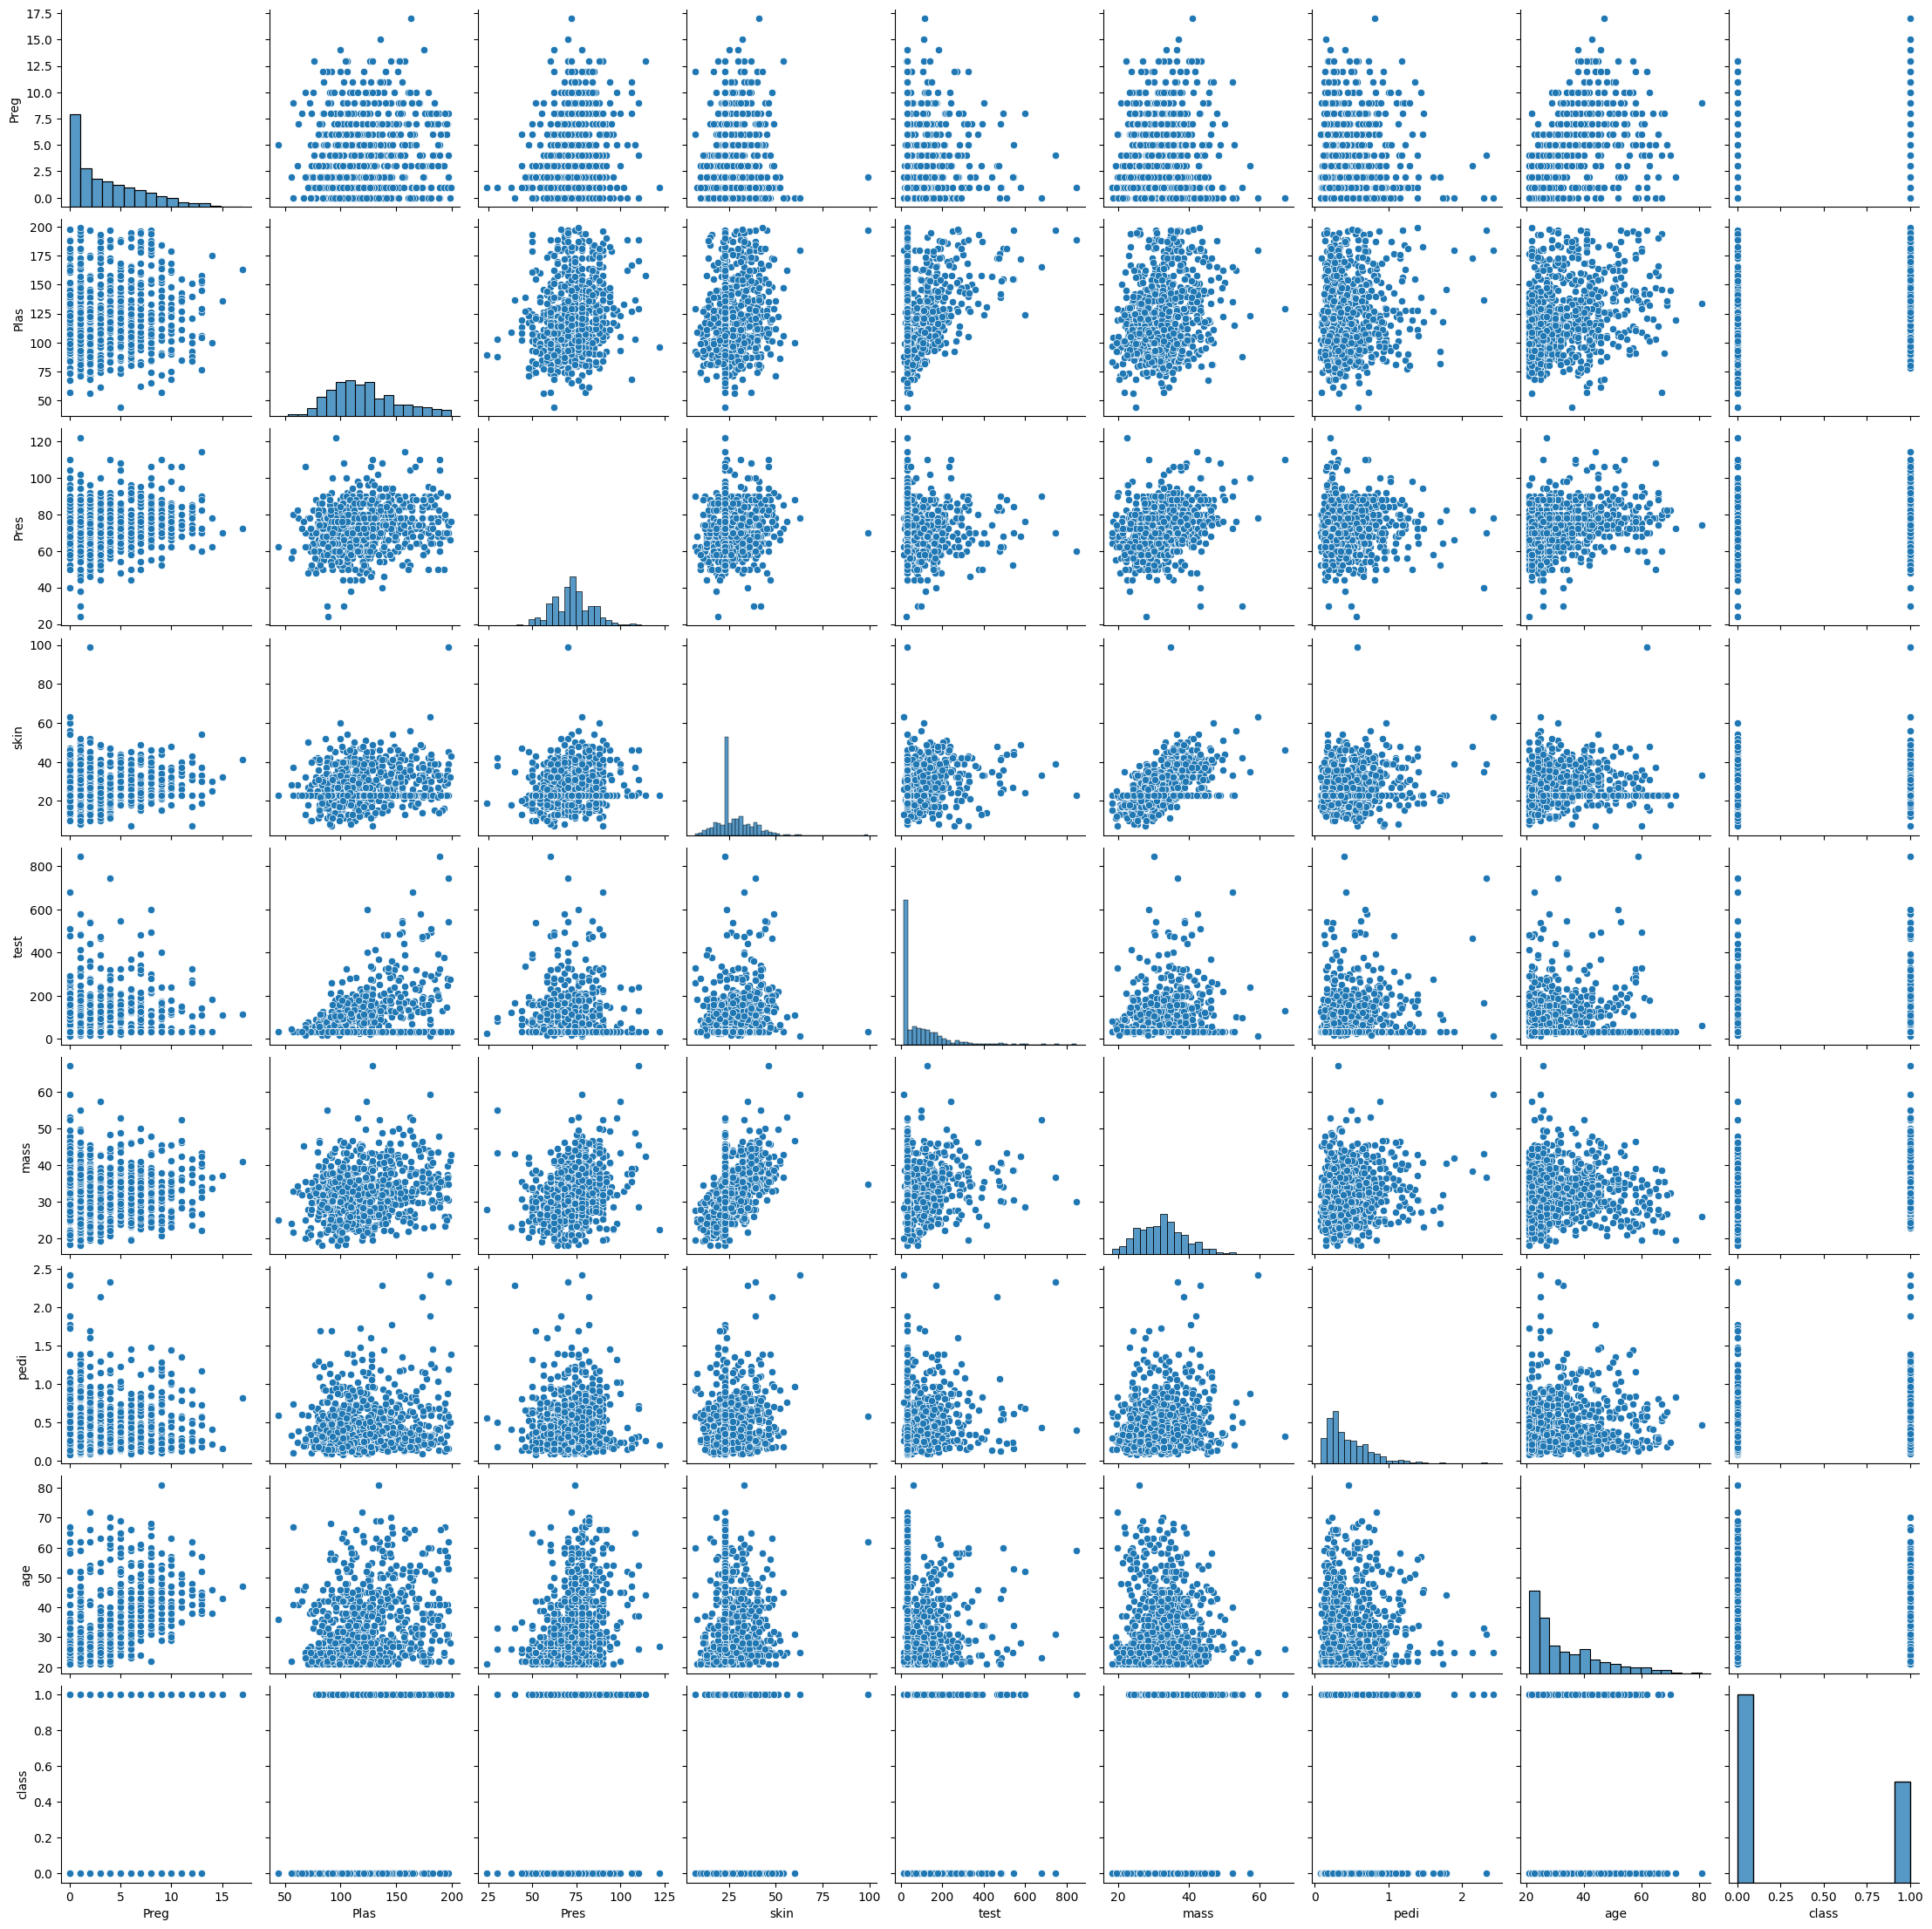

In [17]:
sns.pairplot(df_diab)
plt.show()

######There does not seem to be a direct co-relation between any of the independant variables and target variables, the distribution of both the classes is spread almost equally across the dataset. But there is co-linearity between some of independant features, which we can check with a heatmap to determine if dimensionality reduction is needed.

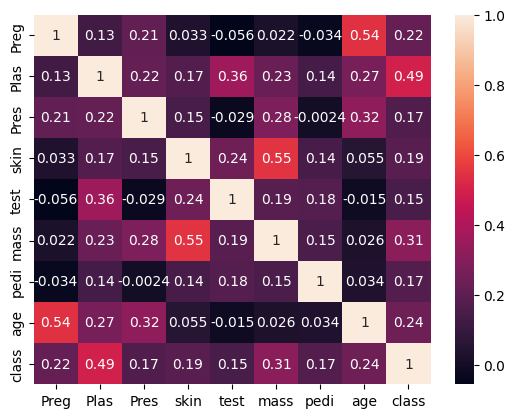

In [18]:
sns.heatmap(df_diab.corr(), annot=True)
plt.show()

######Age and pregnancy seems to share some co-linearity. Simlarly mass and skin are co-linear. However, the co-linearity co-efficient is not so high so we will not go for dimension reduction.

####Normalize the data, split the dataset into training and test sets.

In [19]:
X=df_diab.iloc[:,0:8]

In [20]:
y=df_diab.iloc[:,8]

In [21]:
scaler=StandardScaler()
X_std=scaler.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test=train_test_split(X_std,y,train_size=0.7,random_state=1)
X_test, X_val, y_test, y_val=train_test_split(X_test,y_test,train_size=0.5,random_state=1)

In [23]:
X_train.dtype

dtype('float64')

In [24]:
print(X_train.shape, X_test.shape, X_val.shape)

(537, 8) (115, 8) (116, 8)


In [25]:
print(y_train.dtype, y_test.dtype, y_val.dtype)

int64 int64 int64


#####Using lazypredict to check the best ML Classification Algorithm for this dataset.

In [ ]:
clf=LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test,
                              y_train, y_test)
print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 183, number of negative: 354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 537, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.340782 -> initscore=-0.659811
[LightGBM] [Info] Start training from score -0.659811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

######From the above, it can be seen that B
ExtraTreesClassifier and RandomForestClassifier algorithms are providing an accuracy score of 81%.



In [ ]:
ml_model=RandomForestClassifier()

In [ ]:
ml_model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred=ml_model.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test,y_pred,normalize=True)

0.8

The accuracy score on test dataset is 80%.

In [ ]:
confusion_matrix=metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[66  9]
 [14 26]]


######As per the above confusion matrix, out of the total 115 records from the test dataset, the model has accurately predicted 92 records. Of the rest, the 9 records which are false negative is concerning, as the model is identifying diabetics as non-diabetics. For medical field, this can be a costly error.

## Define a Neural Network using Pytorch

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [27]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [28]:
training_data = dataset(X_train, y_train.to_numpy())
validation_data = dataset(X_val, y_val.to_numpy())
testing_data = dataset(X_test, y_test.to_numpy())

In [29]:
train_dataloader=DataLoader(training_data, batch_size=8, shuffle=True)
val_dataloader=DataLoader(validation_data, batch_size=8, shuffle=True)
test_dataloader=DataLoader(testing_data, batch_size=8, shuffle=True)

In [30]:
HIDDEN_NEURONS1=8
HIDDEN_NEURONS2=4

class myModel(nn.Module):
  def __init__(self):
    super(myModel, self).__init__()
    self.InputLayer=nn.Linear(X.shape[1], HIDDEN_NEURONS1)
    self.HiddenLayer1=nn.Linear(HIDDEN_NEURONS1, HIDDEN_NEURONS2)
    self.relu=nn.ReLU()
    self.HiddenLayer2=nn.Linear(HIDDEN_NEURONS2, 1)
    self.OutputLayer=nn.Sigmoid()

  def forward(self, x):
    x=self.InputLayer(x)
    x=self.HiddenLayer1(x)
    x=self.relu(x)
    x=self.HiddenLayer2(x)
    x=self.OutputLayer(x)
    return x

model=myModel().to(device)

In [44]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              72
            Linear-2                    [-1, 4]              36
              ReLU-3                    [-1, 4]               0
            Linear-4                    [-1, 1]               5
           Sigmoid-5                    [-1, 1]               0
Total params: 113
Trainable params: 113
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [45]:
criterion=nn.BCELoss()
optimizer=Adam(model.parameters(), lr=1e-3)

In [51]:
total_train_acc_plot=[]
total_val_acc_plot=[]
total_train_loss_plot=[]
total_val_loss_plot=[]

epochs=10
for epoch in range(epochs):
  total_train_loss=0
  total_train_acc=0

  for data in train_dataloader:
    inputs, labels = data
    prediction=model(inputs).squeeze(1)
    batch_loss=criterion(prediction, labels)
    total_train_loss+=batch_loss.item()

    acc = ((prediction).round() == labels).sum().item()

    total_train_acc += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    total_val_loss=0
    total_val_acc=0
    for data in val_dataloader:
      inputs, labels = data
      prediction=model(inputs).squeeze(1)
      batch_loss=criterion(prediction, labels)

      total_val_loss+=batch_loss.item()

      acc = ((prediction).round() == labels).sum().item()

      total_val_acc += acc

  total_train_acc_plot.append(round((total_train_acc/(training_data.__len__())*100),4))
  total_val_acc_plot.append(round((total_val_acc/(validation_data.__len__())*100),4))
  total_train_loss_plot.append(round(total_train_loss/1000, 4))
  total_val_loss_plot.append(round(total_val_loss/1000, 4))

  print(f"""Epoch No: {epoch+1} Training Accuracy: {(total_train_acc/(training_data.__len__())*100):.4f} Validation Accuracy: {(total_val_acc/(validation_data.__len__())*100):.4f} Training Loss: {total_train_loss/1000:.4f} Validation Loss:  {total_val_loss/1000:.4f}""")
  print("*"*50)
  """print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
  print("="*50)"""

Epoch No: 1 Training Accuracy: 77.4674 Validation Accuracy: 81.0345 Training Loss: 0.0318 Validation Loss:  0.0065
**************************************************
Epoch No: 2 Training Accuracy: 77.4674 Validation Accuracy: 81.0345 Training Loss: 0.0316 Validation Loss:  0.0064
**************************************************
Epoch No: 3 Training Accuracy: 77.4674 Validation Accuracy: 80.1724 Training Loss: 0.0319 Validation Loss:  0.0066
**************************************************
Epoch No: 4 Training Accuracy: 77.4674 Validation Accuracy: 81.0345 Training Loss: 0.0314 Validation Loss:  0.0064
**************************************************
Epoch No: 5 Training Accuracy: 77.2812 Validation Accuracy: 81.0345 Training Loss: 0.0317 Validation Loss:  0.0064
**************************************************
Epoch No: 6 Training Accuracy: 76.9088 Validation Accuracy: 80.1724 Training Loss: 0.0318 Validation Loss:  0.0066
**************************************************
Epoc

In [205]:
with torch.no_grad():
  total_test_loss=0
  total_test_acc=0
  for data in test_dataloader:
    inputs, labels = data
    prediction=model(inputs).squeeze(1)
    batch_loss=criterion(prediction, labels)

    total_val_loss+=batch_loss.item()

    acc = ((prediction).round() == labels).sum().item()

    total_test_acc += acc
    break
print(f"Test Accuracy: {(total_test_acc/(testing_data.__len__())*100):.4f}")

Test Accuracy: 6.9565


In [207]:
(prediction).round()

tensor([0., 0., 1., 0., 1., 0., 1., 1.])

In [209]:
data

[tensor([[-1.1419, -0.5804, -0.6938, -0.4700,  0.2024, -0.6769, -0.0540, -0.8714],
         [-1.1419, -0.0873, -0.6938, -1.0121, -0.0251,  0.3564,  0.7645, -0.8714],
         [ 0.9369,  1.5235,  1.2916,  1.5901,  2.1459,  0.8367,  0.9517,  0.5751],
         [ 0.3430,  0.2085,  0.6298, -0.4700, -0.6082,  0.3128, -0.9902,  1.0006],
         [ 1.8278,  0.2414, -0.8592,  0.9395, -0.6082,  1.2734, -0.0933,  0.4049],
         [ 0.0460, -1.0407, -0.0320, -0.4700, -0.6082, -0.6478,  0.4171, -0.1907],
         [ 1.5308,  2.0495,  1.0434, -1.3374, -0.6082, -0.3567,  2.2383,  1.3409],
         [-0.8449,  2.5427,  0.2989,  1.6985, -0.6082,  1.5208,  2.7849, -0.9565]]),
 tensor([0., 0., 1., 0., 1., 0., 1., 1.])]

The accuracy score using the Neural Network is approx 80%, similar to that of the ML Algorithms.

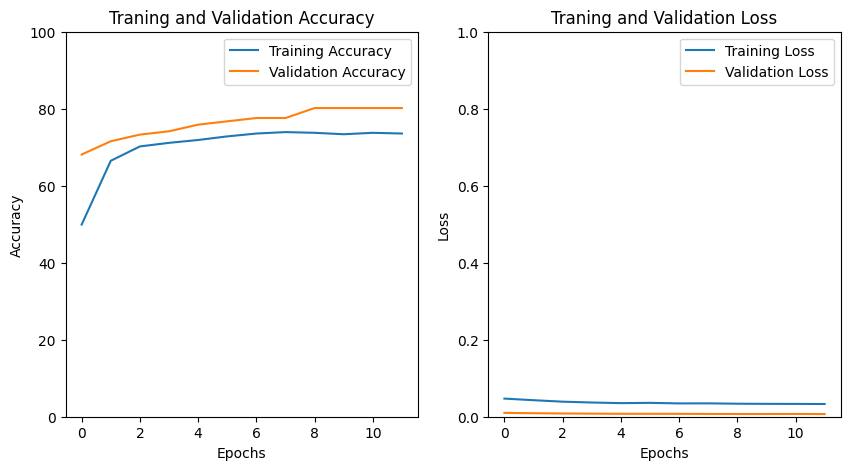

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].plot(total_train_acc_plot,label='Training Accuracy')
axs[0].plot(total_val_acc_plot,label='Validation Accuracy')
axs[0].set_title('Traning and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].set_ylim(0,100)

axs[1].plot(total_train_loss_plot,label='Training Loss')
axs[1].plot(total_val_loss_plot,label='Validation Loss')
axs[1].set_title('Traning and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].set_ylim(0,1)
plt.show()

######We will save both these models and create fastapi  endpoints for model call.

In [ ]:
pickle.dump(ml_model, open('ml_model_pimadiabetes.pkl', 'wb'))

In [ ]:
loaded_model=pickle.load(open('ml_model_pimadiabetes.pkl', 'rb'))

In [ ]:
loaded_model.predict(X_test[0].reshape(1,8))

array([1])

######Save the Pytorch NN model

In [54]:
torch.save(model.state_dict(), 'nn_model_pimadiabetes.pt')

In [31]:
nn_model=myModel()
nn_model.load_state_dict(torch.load('nn_model_pimadiabetes.pt', weights_only=True))
nn_model.eval()

myModel(
  (InputLayer): Linear(in_features=8, out_features=8, bias=True)
  (HiddenLayer1): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (HiddenLayer2): Linear(in_features=4, out_features=1, bias=True)
  (OutputLayer): Sigmoid()
)

In [33]:
prediction_nn=nn_model( torch.tensor(X_test[0].reshape(1,8), dtype = torch.float32).to(device))

In [36]:
prediction_nn.round().item()

1.0